# Παραγωγικά Δίκτυα Μάθησης με Αντιπαλότητα (ΠΔΜΑ) - Generative Adversarial Networks (GAN)

Όπως είπαμε και στη διάλεξη, ένα Παραγωγικό Δίκτυο Μάθησης με Αντιπαλότητα (ΓΔΜΑ) - Generative Adversarial Network (GAN) είναι ένα παραγωγικό (generative) σύστημα μηχανικής μάθησης το οποίο [προτάθηκε  από τον Goodfellow το 2014](https://arxiv.org/abs/1406.2661), και αποτελείται από δύο διακριτά νευρωνικά δίκτυα:
1. Τον γεννήτορα (generator), ο οποίος προσπαθεί να δημιουργήσει νέα δείγματα δεδομένων, όμοια προς τα υπάρχοντα
2. Τον διευκρινιστή (discriminator), ο οποίος καλείται να αναγνωρίσει αν ένα δείγμα δεδομένων είναι "αληθινό" ή "ψεύτικο"

Η είσοδος του δικτύου του γεννήτορα είναι μια σειρά τυχαίων αριθμών (θορύβου), τα οποία καλούνται λανθάνοντα δείγματα (latent samples). Όπως είπαμε και παραπάνω, ο γεννήτορας  προσπαθεί να δημιουργήσει δείγματα, τα οποία τελικά προέρχονται από την επιθυμητή κατανομή των δεδομένων. Ο θόρυβος που λαμβάνει στην είσοδό του διέρχεται μέσω των διαφορίσημων συναρτήσεων ενεργοποίησης του δικτύου και μετασχηματίζεται, μέσω της εκπαίδευσης, με τέτοιο τρόπο έτσι ώστε στην έξοδό του να παράξει "ρεαλιστικά δεδομένα". Άρα, στη συγκεκριμένη περίπτωση, ο ρόλος της εισόδου είναι η εισαγωγή τυχαιότητας στο σύστημα, η οποία επιτρέπει στον γεννήτορα να παράξει εξόδους που θα καλύπτουν όλο το εύρος των υπό εξέταση δεδομένων.

Το δίκτυο του διευκρινιστή από την άλλη αποτελείται από έναν ταξινομητή, ο οποίος εκπαιδεύεται μέσω επιβλεπόμενης μάθησης σε ένα dataset και μαθαίνει να αναγνωρίζει αν η έξοδος που παράγει ο γεννήτορας ανταποκρίνεται στα δεδομένα στα οποία έχει εκπαιδευτεί ο διευκρινιστής ή όχι.

Η εκπαίδευση ενός GAN προσομοιάζει με ένα παιχνίδι minmax. Ο γεννήτορας προσπαθεί να μάθει να δημιουργεί δεδομένα με τέτοιο τρόπο που ο διευκρινιστής δε θα μπορεί πλέον να αναγνωρίζει αν είναι ψεύτικα ή όχι. Ο ανταγωνισμός αυτός μεταξύ των δύο δικτύων βελτιώνει τη δυνατότητα μάθησης του συνολικού δικτύου, μέχρις ότου ο γεννήτορας μάθει να δημιουργεί "ρεαλιστικά" δεδομένα.

Στο συγκεκριμένο notebook θα δούμε πως μπορούμε να χρησιμοποιήσουμε τα GANs για την παραγωγή εικόνων ψηφίων, παρόμοιων με αυτά που υπάρχουν στο γνωστό μας [MNIST dataset](http://yann.lecun.com/exdb/mnist/).

Για την ταχύτερη εκτέλεση του κώδικα, στην περίπτωση που χρησιμοποιείτε Google Colaboratory, συστήνεται να επιλέξετε τις κάρτες γραφικών ως τον επιταχυντή υλικού (hardware accelerator). Αυτό επιτυγχάνεται επιλέγοντας το μενού Runtime και στη συνέχεια το υπομενού Change Runtime type. Στο νέο παράθυρο που θα εμφανιστεί επιλέγουμε GPU στο hardware accelerator και κατόπιν Save.

Η εκπαίδευση των GANs στα κελιά που θα ακολουθήσουν θα χρειαστεί κάποιο χρόνο, οπότε ενδέχεται να εμφανιστεί παράθυρο σφάλματος με τίτλο “Runtime disconnected” και μήνυμα “The connection to the runtime has timed out”. Σε αυτή την περίπτωση πατάμε “Reconnect” και συνδεόμαστε ξανά με το περιβάλλον εκτέλεση του κώδικα.

## Βιβλιοθήκες

Ξεκινάμε εισάγοντας τις βιβλιοθήκες που πρόκειται να χρησιμοποιήσουμε (κυρίως το *keras* και δευτερευόντως το *scikit-learn,* το *numpy* και το *matplotlib*)

In [ ]:
from keras import backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, Conv2DTranspose, Dense
from tensorflow.keras.layers import Flatten, Input, LeakyReLU, ReLU, Reshape
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.initializers import RandomNormal
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import matplotlib.pyplot as plt

# Θέτουμε συγκεκριμένη «σπορά» στη γεννήτρια ψευδοτυχαίων αριθμών για να 
# μπορούμε να αναπαράξουμε τα αποτελέσματα
np.random.seed(2022)
%matplotlib inline

### Dataset

Αρχικά φορτώνουμε το MNIST Dataset από το keras

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Ας δούμε μια χαρακτηριστική εικόνα (ψηφίο) για την κάθε ετικέτα

In [ ]:
fig = plt.figure()
for i in range(10):
    plt.subplot(2, 5, i+1)
    x_y = X_train[y_train == i]
    plt.imshow(x_y[0], cmap='gray', interpolation='none')
    plt.title("Κλάση %d" % (i))
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()

Μετασχηματίζουμε τις εικόνες από πίνακα $28\times28$ pixels σε να διάνυσμα $784$ χαρακτηριστικών. Επίσης τους αλλάζουμε κλίμακα, απεικονίζοντάς τες γραμμικά από το $[0, 255]$ στο $[-1,1]$ με την χρήση του [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) του scikit-learn

In [ ]:
print('Διαστάσεις X_train:', X_train.shape)

# μετασχηματισμός εικόνας σε διάνυσμα
X_train = X_train.reshape(60000, 28*28)
# κανονικοποίηση στο [-1,1]
scaler = MinMaxScaler(feature_range=(-1,1))

X_train_scaled = scaler.fit_transform(X_train)

print('Διαστάσεις X_train_scaled:', X_train_scaled.shape)

## Simple GAN

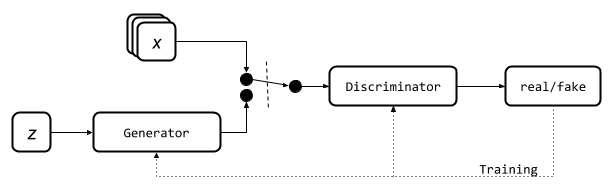

Η αντικειμενική συνάρτηση που προσπαθεί να βελτιστοποιήσει το απλό GAN εναι η παρακάτω:

 $ \underset{\theta_{g}}{min} \: \underset{\theta_{d}}{max} V(D,G) = \mathbb{E}_{x\sim p_{data}(x)} [log D_{\theta_{d}}(x)] + \mathbb{E}_{z\sim p_{z}(z)}[log(1 - D_{\theta_{d}}(G_{\theta_{g}}(z)))]$
 

*  Ο διευκρινιστής $D$ θέλει να μεγιστοποιήσει την αντικειμενική συνάρτηση όσον αφορά τις παραμέτρους του ($\theta_d$), έτσι ώστε το $D(x)$ να είναι κατά το δυνατόν εγγύτερα στο $1$ (αληθινά δεδομένα) και το $D(G(z))$ κοντά στο $0$ (ψευδή δεδομένα)
*  Ο γεννήτορας $G$ θέλει να ελαχιστοποιήσει την αντικειμενική συνάρτηση όσον αφορά τις παραμέτρους του ($\theta_g$), έτσι ώστε το $D(G(z))$ να είναι εγγύτερα στο $1$

Ξεκινάμε ορίζοντας το μέγεθος του χώρου των λανθανουσών μεταβλητών $z$, ο οποίος πρόκειται να είναι ένα διάνυσμα μεγέθους $100$ χαρακτηριστικών 

In [ ]:
# διάσταση χώρου λανθανουσών μεταβλητών z
latent_dim = 100

# διάσταση εικόνας 
img_dim = 28*28


Το δίκτυο του γεννήτορα είναι ένα πλήρως διασυνδεδεμένο βαθύ δίκτυο $3$ κρυφών επιπέδων, μεγέθους $128, 256$ και $512$ νευρώνων αντίστοιχα.

In [ ]:
# Δίκτυο γεννήτορα
generator = Sequential([
    # Επίπεδο εισόδου και 1ο κρυφό επίπεδο
    Dense(128, input_shape=(latent_dim,), 
          kernel_initializer=RandomNormal(stddev=0.02)),
    LeakyReLU(alpha=0.2),
    BatchNormalization(momentum=0.8),
    
    # 2ο κρυφό επίπεδο
    Dense(256),
    LeakyReLU(alpha=0.2),
    BatchNormalization(momentum=0.8),
    
     # 3ο κρυφό επίπεδο
    Dense(512),
    LeakyReLU(alpha=0.2),
    BatchNormalization(momentum=0.8),
    
    # Επίπεδο εξόδου 
    Dense(img_dim, activation='tanh')
])

# Σύνοψη δικτύου
generator.summary()

Το δίκτυο του διευκρινιστή έχει αντίστοιχη δομή με αυτή του γεννήτορα, με τη διαφορά πως αλλάζει η είσοδος και η έξοδος.

In [ ]:
# Δίκτυο Διευκρινιστή
discriminator = Sequential([
  # Επίπεδο εισόδου και 1ο κρυφό επίπεδο    
  Dense(128, input_shape=(img_dim,), 
        kernel_initializer=RandomNormal(stddev=0.02)),
  LeakyReLU(alpha=0.2),
    
  # 2ο κρυφό επίπεδο
  Dense(256),
  LeakyReLU(alpha=0.2),

  # 3ο κρυφό επίπεδο
  Dense(512),
  LeakyReLU(alpha=0.2),

  # Επίπεδο εξόδου
  Dense(1, activation='sigmoid')
])

# Σύνοψη μοντέλου
discriminator.summary()

discriminator.compile(optimizer=Adam(learning_rate=2e-4, beta_1=0.5), 
                      loss='binary_crossentropy', metrics=['binary_accuracy'])

discriminator.trainable = False

Πλέον, είμαστε έτοιμοι να ορίσουμε το συνολικό GAN

In [ ]:
gan = Sequential([
    generator,
    discriminator
])

# Σύνοψη μοντέλου
gan.summary()

gan.compile(optimizer=Adam(learning_rate=2e-4, beta_1=0.5), 
            loss='binary_crossentropy', metrics=['binary_accuracy'])

Με βάση την αντικειμενική συνάρτηση που ορίσαμε παραπάνω, έχουμε δύο εναλλασόμενα στάδια εκπαίδευσης.

1. Ανάβαση κλίσης (μεγιστοποίηση) για τον διευκρινιστή <br>
$ \underset{\theta_{d}}{max} \left[\mathbb{E}_{x\sim p_{data}(x)} log D_{\theta_{d}}(x) + \mathbb{E}_{z\sim p_{z}(z)}\left(log(1 - D_{\theta_{d}}(G_{\theta_{g}}(z)))\right)\right]$

2. Κατάβαση κλίσης (ελαχιστοποίηση) για τον γεννήτορα <br>
$ \underset{\theta_{g}}{min} \left[\mathbb{E}_{z\sim p_{z}(z)}\left(log(1 - D_{\theta_{d}}(G_{\theta_{g}}(z)))\right)\right]$

Ο γεννήτορας δηλαδή, προσπαθεί να ελαχιστοποιήσει την πιθανότητα ο διευκρινιστής να είναι σωστός. Ωστόσο,  στη συγκεκριμένη περίπτωση, θα χρησιμοποιήσουμε έναν εναλλακτικό τρόπο: ο γεννήτορας θα προσπαθεί να μεγιστοποιήσει την πιθανότητα ο διευκρινιστής να είναι λάθος, δηλαδή:<br>
$ \underset{\theta_{g}}{max} \left[\mathbb{E}_{z\sim p_{z}(z)}\left(log(D_{\theta_{d}}(G_{\theta_{g}}(z)))\right)\right]$

Κατ' αυτόν τον τρόπο, ενώ το αντικείμενο της εκπαίδευσης δεν αλλάζει, εντούτοις διασφαλίζουμε υψηλότερες κλίσεις για την εκπαίδευση του γεννήτορα, πράγμα που οδηγεί σε πιο γρήγορη εκπαίδευση.

Συμπερασματικά, ο διευκρινιστής εκπαιδεύεται κανονικά όπως ένας ταξινομητής, στο να αναγνωρίζει αν η είσοδός του είναι αληθής η ψευδής. Ο γεννήτορας από την άλλη εκπαιδεύεται στο να παράγει κατά το δυνατόν ρεαλιστικά δεδομένα, έτσι ώστε να "ξεγελά" τον διευκρινιστή. Συνεπώς, σε αυτή την περίπτωση, η συνάρτηση απώλειας που χρησιμοποιείται είναι η $D(G(z))$



In [ ]:
epochs = 50
batch_size = 64
smooth = 0.1

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

d_loss_gan = []
gan_loss = []

# Δημιουργία 10 δειγμάτων από το γεννήτορα πριν την εκπαίδευση του GAN
samples = 10
x_fake = generator.predict(
    np.random.normal(loc=0, scale=1, size=(samples, latent_dim))
)

for k in range(samples):
    plt.subplot(2, 5, k+1)
    plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()

for e in range(epochs):
    for i in range(len(X_train) // batch_size):
        
        # "Ξεπάγωμα" (εκπαίδευση) βαρών διευκρινιστή
        discriminator.trainable = True
        
        # Δείγματα αληθινών εικόνων
        X_batch = X_train_scaled[i*batch_size:(i+1)*batch_size]
        d_loss_gan_real = discriminator.train_on_batch(
            x=X_batch, y=real * (1 - smooth)
        )
        
        # Δείγματα "ψεύτικων" εικόνων (παραγόμενα από τον γεννήτορα)
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        X_fake = generator.predict_on_batch(z)
        d_loss_gan_fake = discriminator.train_on_batch(x=X_fake, y=fake)
         
        # Υπολογίσμος συνάρτησης απώλειας GAN
        d_loss_gan_batch = 0.5 * (d_loss_gan_real[0] + d_loss_gan_fake[0])
        
        # "Πάγωμα" των βαρών του διευκρινιστή
        discriminator.trainable = False
        gan_loss_batch = gan.train_on_batch(x=z, y=real)
   

    d_loss_gan.append(d_loss_gan_batch)
    gan_loss.append(gan_loss_batch[0])
    print('Εποχή: %d/%d, Απώλεια Διευκρινιστή: %.3f, Απώλεια GAN: %.3f' % 
          (e + 1, epochs, d_loss_gan[-1], gan_loss[-1]))

    if (e + 1) % 10 == 0:
        samples = 10
        x_fake = generator.predict(
            np.random.normal(loc=0, scale=1, size=(samples, latent_dim))
        )

        for k in range(samples):
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.show()

Τέλος, ας σχεδιάσουμε τη μεταβολή των συναρτήσεων απώλειας για τον διευκρινιστή καθώς και για το συνολικό δίκτυο

In [ ]:
plt.plot(d_loss_gan)
plt.plot(gan_loss)
plt.title('Απώλεια Μοντέλων')
plt.ylabel('Απώλεια')
plt.xlabel('Εποχή')
plt.legend(['Διευκρινιστής', 'GAN'], loc='upper right')
plt.show()

Παρατηρούμε ότι οι συναρτήσεις απώλειας του διευκρινιστή και του GAN σταθεροποιούνται μετά την 20ή εποχή.